In [1]:
import numpy as np

class AABB:
    """轴对齐包围盒(Axis-Aligned Bounding Box)"""
    def __init__(self, min_point, max_point):
        self.min_point = np.array(min_point)
        self.max_point = np.array(max_point)
    
    def intersects(self, other):
        """检查与另一个AABB是否相交"""
        return np.all(self.min_point <= other.max_point) and \
               np.all(other.min_point <= self.max_point)
    
    def merge(self, other):
        """合并两个AABB"""
        min_point = np.minimum(self.min_point, other.min_point)
        max_point = np.maximum(self.max_point, other.max_point)
        return AABB(min_point, max_point)

class BVHNode:
    """BVH树节点"""
    def __init__(self, aabb, objects=None):
        self.aabb = aabb  # 节点的包围盒
        self.objects = objects or []  # 叶节点包含的物体
        self.left = None  # 左子节点
        self.right = None  # 右子节点
        
class BVH:
    """BVH树结构"""
    def __init__(self, objects, max_objects_per_node=4):
        self.max_objects_per_node = max_objects_per_node
        self.root = self._build_bvh(objects)
    
    def _build_bvh(self, objects):
        if not objects:
            return None
        
        # 计算所有物体的AABB
        aabbs = [obj.get_aabb() for obj in objects]
        node_aabb = aabbs[0]
        for aabb in aabbs[1:]:
            node_aabb = node_aabb.merge(aabb)
            
        node = BVHNode(node_aabb, objects)
        
        # 如果物体数量小于阈值，创建叶节点
        if len(objects) <= self.max_objects_per_node:
            return node
        
        # 选择最长轴进行分割
        extents = node_aabb.max_point - node_aabb.min_point
        axis = np.argmax(extents)
        
        # 根据中心点排序
        objects.sort(key=lambda obj: obj.get_center()[axis])
        mid = len(objects) // 2
        
        # 递归构建左右子树
        node.left = self._build_bvh(objects[:mid])
        node.right = self._build_bvh(objects[mid:])
        
        return node
    
    def check_collision(self, query_aabb):
        """检查给定AABB与BVH树中物体的碰撞"""
        def _check_node(node):
            if node is None:
                return []
                
            # 如果查询AABB与节点AABB不相交，直接返回
            if not query_aabb.intersects(node.aabb):
                return []
                
            collisions = []
            
            # 如果是叶节点，检查所有物体
            if node.objects:
                for obj in node.objects:
                    if query_aabb.intersects(obj.get_aabb()):
                        collisions.append(obj)
            else:
                # 递归检查子节点
                collisions.extend(_check_node(node.left))
                collisions.extend(_check_node(node.right))
                
            return collisions
            
        return _check_node(self.root)

# 示例使用
class GameObject:
    def __init__(self, center, size):
        self.center = np.array(center)
        self.size = np.array(size)
        
    def get_aabb(self):
        half_size = self.size / 2
        return AABB(self.center - half_size, self.center + half_size)
        
    def get_center(self):
        return self.center

# 创建测试对象
objects = [
    GameObject([1, 1, 1], [2, 2, 2]),
    GameObject([5, 5, 5], [1, 1, 1]),
    GameObject([3, 3, 3], [1.5, 1.5, 1.5]),
    GameObject([0, 0, 0], [1, 1, 1])
]

# 构建BVH树
bvh = BVH(objects)

# 进行碰撞检测
query_aabb = AABB([0, 0, 0], [2, 2, 2])
collisions = bvh.check_collision(query_aabb)
print(f"Found {len(collisions)} colliding objects")

Found 2 colliding objects


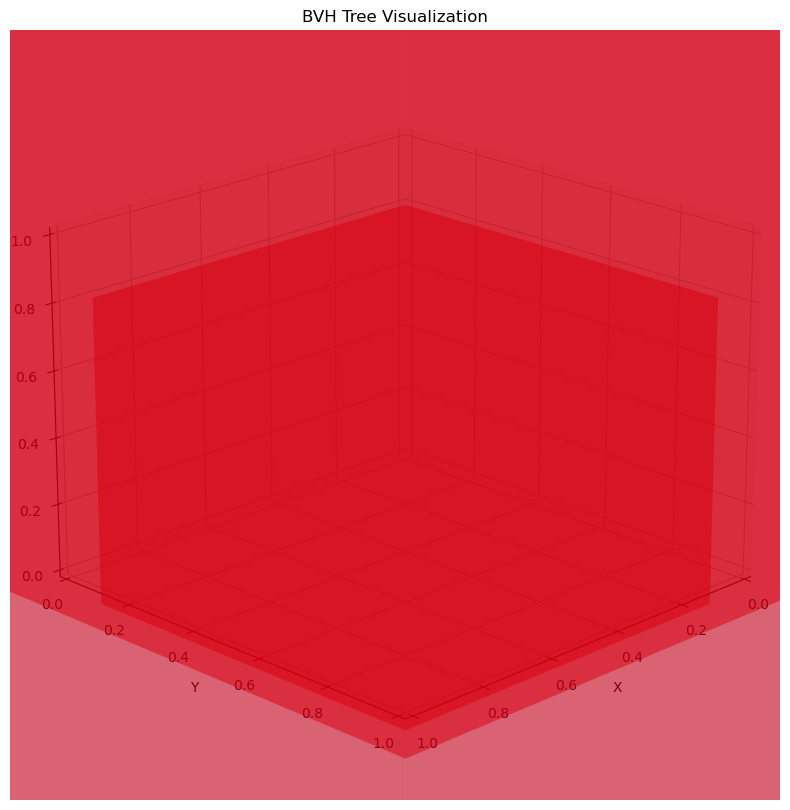

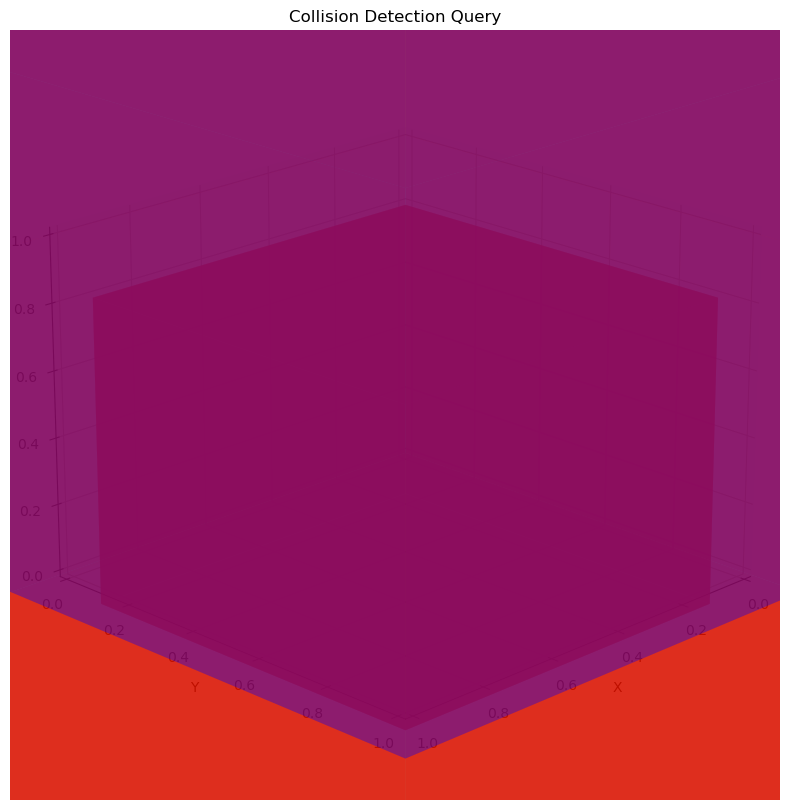

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np

def plot_aabb(ax, aabb, color='b', alpha=0.1):
    """绘制AABB包围盒"""
    min_point = aabb.min_point
    max_point = aabb.max_point
    
    # 定义8个顶点
    vertices = np.array([
        [min_point[0], min_point[1], min_point[2]],
        [max_point[0], min_point[1], min_point[2]],
        [max_point[0], max_point[1], min_point[2]],
        [min_point[0], max_point[1], min_point[2]],
        [min_point[0], min_point[1], max_point[2]],
        [max_point[0], min_point[1], max_point[2]],
        [max_point[0], max_point[1], max_point[2]],
        [min_point[0], max_point[1], max_point[2]]
    ])
    
    # 定义6个面
    faces = [
        [vertices[0], vertices[1], vertices[2], vertices[3]],  # 底面
        [vertices[4], vertices[5], vertices[6], vertices[7]],  # 顶面
        [vertices[0], vertices[1], vertices[5], vertices[4]],  # 前面
        [vertices[2], vertices[3], vertices[7], vertices[6]],  # 后面
        [vertices[1], vertices[2], vertices[6], vertices[5]],  # 右面
        [vertices[0], vertices[3], vertices[7], vertices[4]]   # 左面
    ]
    
    collection = Poly3DCollection(faces, alpha=alpha, facecolor=color)
    ax.add_collection3d(collection)

def visualize_bvh(bvh):
    """可视化BVH树结构"""
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    def plot_node(node, depth=0):
        if node is None:
            return
            
        # 绘制节点的AABB
        color = plt.cm.viridis(depth / 6)  # 不同深度使用不同颜色
        plot_aabb(ax, node.aabb, color=color, alpha=0.1)
        
        # 如果是叶节点，绘制包含的物体
        if node.objects:
            for obj in node.objects:
                plot_aabb(ax, obj.get_aabb(), color='r', alpha=0.3)
        
        # 递归绘制子节点
        plot_node(node.left, depth + 1)
        plot_node(node.right, depth + 1)
    
    # 绘制BVH树
    plot_node(bvh.root)
    
    # 设置坐标轴
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('BVH Tree Visualization')
    
    # 调整视角
    ax.view_init(elev=20, azim=45)
    plt.show()

def visualize_collision_query(bvh, query_aabb, collisions):
    """可视化碰撞检测查询"""
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # 绘制查询AABB
    plot_aabb(ax, query_aabb, color='g', alpha=0.3)
    
    # 绘制发生碰撞的物体
    for obj in collisions:
        plot_aabb(ax, obj.get_aabb(), color='r', alpha=0.5)
    
    # 绘制所有物体
    def plot_node(node):
        if node is None:
            return
        if node.objects:
            for obj in node.objects:
                if obj not in collisions:
                    plot_aabb(ax, obj.get_aabb(), color='b', alpha=0.2)
        plot_node(node.left)
        plot_node(node.right)
    
    plot_node(bvh.root)
    
    # 设置坐标轴
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Collision Detection Query')
    
    # 调整视角
    ax.view_init(elev=20, azim=45)
    plt.show()

# 使用之前的测试代码
# ...existing code...

# 可视化BVH树结构
visualize_bvh(bvh)

# 可视化碰撞检测
visualize_collision_query(bvh, query_aabb, collisions)